In [1]:
import pandas as pd
import numpy as np
import glob
from uimfpy.UIMFReader import *
import matplotlib.pyplot as plt
import pickle

# pipeline
1. identify the peak candidates in the sample of high concentrations
2. check the distribution of LC and IMS peak widths.
2. visually check out the IMS peak in different concentrations (any shift? or any peak shape change?)

## Read detected heavy peaks

In [126]:
ppm = 20
th_peak_area = 1000
th_isotope_lc_cosine = 0.85
masking_threshold = 0.1 # masking threshold (e.g. 0.1 means cut-off by 10% of local maximum)
frames_for_peak=None
scans_for_peak=None

# frames_for_peak=20
# scans_for_peak=20

data_folder = '/Volumes/UserData/SLIM II LC/For Joon/23July2019/'
dfs = []
for concen in [78, 156, 312, 625, 1250, 2500, 5000]:
    uimf = data_folder+'LC_{0}_heavy_repA_1_MinInt5_DComp5.uimf'.format(concen)
    xic2d_file = data_folder+'LC_{0}_heavy_repA_1_MinInt5_DComp5_50ppm.pkl'.format(concen)
    if (frames_for_peak is None) | (scans_for_peak is None):
        peak_out_file = data_folder+ \
                'LC_{0:d}_heavy_repA_1_MinInt5_DComp5_heavy_peaks_{1:d}ppm_area{2:d}_cosine{3:.2f}_mask{4:.1f}.csv'.format(
                    concen, ppm, th_peak_area, th_isotope_lc_cosine, masking_threshold)
    else:
        peak_out_file = data_folder+ \
                'LC_{0:d}_heavy_repA_1_MinInt5_DComp5_heavy_peaks_{1:d}ppm_area{2:d}_cosine{3:.2f}_f{4:d}_s{5:d}.csv'.format(
                    concen, ppm, th_peak_area, th_isotope_lc_cosine, frames_for_peak, scans_for_peak)
    
    df = pd.read_csv(peak_out_file, index_col=0)
    df['concentration'] = concen
    dfs.append(df)
heavy_peaks = pd.concat(dfs, ignore_index=True)

In [55]:
heavy_peaks.head()

,M1_area,M1_cosine,M2_area,M2_cosine,frame,frame_end,frame_start,peak_area,scan,scan_end,scan_start,pepseq,mono_mass,iso_mass,iso,z,concentration
0,369,0.856158,271566,0.952731,166,176,156,74957,529,539,519,TLEPVKPPTVPNDY[+80]MTSPAR[+10],1152.054478,1152.054478,0,2,78
1,26632,0.994581,10431,0.987372,776,786,766,42149,472,482,462,TLEPVKPPTVPNDY[+80]MTSPAR[+10],1152.054478,1152.054478,0,2,78
2,53739,0.977968,31286,0.981662,167,177,157,40390,419,429,409,TLEPVKPPTVPNDY[+80]MTSPAR[+10],1152.054478,1152.054478,0,2,78
3,32311,0.974802,20195,0.975956,122,132,112,29771,441,451,431,TLEPVKPPTVPNDY[+80]MTSPAR[+10],1152.054478,1152.054478,0,2,78
4,24886,0.988701,5125,0.981464,1329,1339,1319,27399,457,467,447,TLEPVKPPTVPNDY[+80]MTSPAR[+10],1152.054478,1152.054478,0,2,78


In [ ]:
##### 

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from CollectHeavyTargetPeaks import xic_matrix, read_target_list, collect_target_mzbins, find_mzbin_infos
from uimfpy.UIMFReader import *
    
n_frames = 2200
n_scans = 1047
concentrations = [0, 78, 156, 312, 625, 1250, 2500, 5000]
colors = sns.color_palette("Paired")
colors_by_concentrations = dict()
for con, color in zip(concentrations, colors):
    colors_by_concentrations[con] = color

In [122]:
def find_peaks(all_peaks, pepseq, z, concentration=None):
    assert 'pepseq' in all_peaks.columns, print('all_peaks MUST has the pepseq column')
    assert 'z' in all_peaks.columns, print('all_peaks MUST has the z column')
    assert 'concentration' in all_peaks.columns, print('all_peaks MUST has the concentration column')
    
    if concentration:
        tdf = all_peaks[(all_peaks.pepseq==pepseq)&(all_peaks.z==z)&(all_peaks.concentration==concentration)]
    else:
        tdf = all_peaks[(all_peaks.pepseq==pepseq)&(all_peaks.z==z)]
    return tdf.copy()

def make_rects(ax, peak_list, conds=None):    
    for peak in peak_list:
        frame_start = peak['frame_start']
        frame_end = peak['frame_end']
        scan_start = peak['scan_start']
        scan_end = peak['scan_end']
        concentration = peak['concentration']
        
        if conds:
            for cond in conds:
                if conds == 'concentration':
                    if peak[cond]==conds[cond]: continue
                elif peak[cond]<conds[cond]: continue
        
        rect = patches.Rectangle((frame_start,scan_start),frame_end-frame_start,scan_end-scan_start,linewidth=1,edgecolor=colors_by_concentrations[concentration],facecolor='none')
        ax.add_patch(rect)
    
def plot_peak_regions(ax, all_peaks, pepseq, z, concentration=None, conds=None):
    tdf = find_peaks(all_peaks, pepseq, z, concentration)
    
    frame_max = tdf.frame_end.max()
    frame_min = tdf.frame_start.min()
    scan_max = tdf.scan_end.max()
    scan_min = tdf.scan_start.min()
    
    # Create figure and axes
    #fig, ax = plt.subplots(1)
    
    # Create a Rectangle patch
    rects = make_rects(ax, tdf.to_dict('record'), conds)
    
    # Add dummy for color legends
    for i in [78, 156, 312, 625, 1250, 2500, 5000]:
        ax.plot(0,0, color=colors_by_concentrations[i], label=i)
    
    ax.legend()
    ax.set_xlim([frame_min-100,frame_max+100])
    ax.set_ylim([scan_min-100,scan_max+100])

def plot_mobilogram(ax, xic2d_mono, peak, color='r', label=''):
    mobilo_by_scan = xic2d_mono[peak['frame_start']:peak['frame_end'],:].sum(axis=0)
    ax.plot(mobilo_by_scan.reshape((-1, 1)), color=color, label=label)
    ax.axvline(peak['scan_start'], ls=':')
    ax.axvline(peak['scan_end'], ls=':')
    ax.set_xlim((peak['scan_start']-100,peak['scan_end']+100))
    
def plot_chromatogram(ax, xic2d_mono, peak, color='r', label=''):
    chrom_by_frame = xic2d_mono[:,peak['scan_start']:peak['scan_end']].sum(axis=1)
    ax.plot(chrom_by_frame, color=color, label=label)
    ax.axvline(peak['frame_start'], ls=':')
    ax.axvline(peak['frame_end'], ls=':')
    ax.set_xlim((peak['frame_start']-100,peak['frame_end']+100))
    
def plot_mobilograms_by_peak(uimf_files, xic_by_mzbin_objs, colors, target_list_file, all_peaks, peak, ppm, conds=None):
    print("#"*100)
    stime = time.time()
    
    print(peak)
    
    fig1, ax1 = plt.subplots(2,1, figsize=(10,10))
    fig2, ax2 = plt.subplots(2,1, figsize=(10,10))
    for concen, uimf_file, xic_by_mzbin, color in zip([78, 156, 312, 625, 1250, 2500, 5000], uimf_files, xic_by_mzbin_objs, colors):
        reader = UIMFReader(uimf_file, TIC_threshold=0)
        target_df = read_target_list(target_list_file, sheet_name=0)
        #print('# ready targets:{0},'.format(target_df.shape[0]), (time.time()-stime)/60, 'min')
        target_mzbins, mzbins_by_mz = collect_target_mzbins(target_df, reader.mz_calibrator_by_params, ppm=ppm, isotope=0, heavy_only=False)
        #print('# ready target m/z bins,', (time.time()-stime)/60, 'min')

        mono_info = find_mzbin_infos(mzbins_by_mz, peak['pepseq'], 0, peak['z'])
        xic2d_mono = xic_matrix(xic_by_mzbin, mzbins_by_mz[mono_info], reader.num_frames, reader.num_scans, normalize=False)
        
        # Create a Rectangle patch
        plot_mobilogram(ax1[0], xic2d_mono, peak, color=color, label=uimf_file)
        plot_chromatogram(ax1[1], xic2d_mono, peak, color=color, label=uimf_file)
        
        if peak['concentration'] == concen:
            img = xic2d_mono/xic2d_mono.max()
            ax2[0].imshow(img.T, origin='lower')
            ax2[1].imshow(img.T, origin='lower')
            plot_peak_regions(ax2[0], all_peaks, peak['pepseq'], peak['z'], concentration=concen, conds=conds)
            plot_peak_regions(ax2[1], all_peaks, peak['pepseq'], peak['z'], conds=conds)
    
    # ax.legend()
    plt.show()

{'pepseq': 'TLEPVKPPTVPNDY[+80]MTSPAR[+10]', 'mono_mass': 1152.054478, 'z': 2}


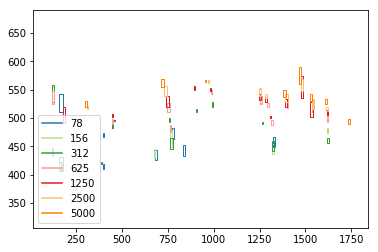

In [82]:
conds = {'M1_area':1000, 'M2_area':1000, 'M1_cosine':0.9, 'M2_cosine':0.9}
unique_peptides = heavy_peaks[['pepseq','mono_mass','z']].drop_duplicates().to_dict('records')
for pep in unique_peptides:
    print(pep)
    fig, ax = plt.subplots()
    plot_peak_regions(ax, heavy_peaks, pep['pepseq'], pep['z'], conds)
    break

In [10]:
uimf_files = []
xic_by_mzbin_objs = []
colors = []

data_folder = '/Users/leej324/Downloads/LC_SLIM/'
target_list_file = data_folder+'20190319-Slim charge1-5 light-heavy.xlsx'
stime = time.time()
for concen in [78, 156, 312, 625, 1250, 2500, 5000]:
    uimf = data_folder+'LC_{0}_heavy_repA_1_MinInt5_DComp5.uimf'.format(concen)
    xic2d_file = data_folder+'LC_{0}_heavy_repA_1_MinInt5_DComp5_50ppm.pkl'.format(concen)
    
    reader = UIMFReader(uimf, TIC_threshold=0)
    target_df = read_target_list(target_list_file, sheet_name=0)
    print('# ready targets:{0},'.format(target_df.shape[0]), (time.time()-stime)/60, 'min')
    target_mzbins, mzbins_by_mz = collect_target_mzbins(target_df, reader.mz_calibrator_by_params, ppm=40, isotope=1, heavy_only=True)
    print('# ready target m/z bins,', len(target_mzbins[('0.347577', '0.0549547', '1.0')]), (time.time()-stime)/60, 'min')

    uimf_files.append(uimf)
    try:
        with open(xic2d_file, 'rb') as handle:
            xic_by_mzbins = pickle.load(handle)
    except FileNotFoundError:
        print("[ERR] There is no target_xic2d_file: %s" % xic2d_file)
    print('# ready 2d xic_by_mzbins,', len(xic_by_mzbins), (time.time()-stime)/60, 'min')
    xic_by_mzbins = {k: xic_by_mzbins[k] for k in xic_by_mzbins.keys() & set(target_mzbins[('0.347577', '0.0549547', '1.0')])}
    print('# filtered 2d xic_by_mzbins,', len(xic_by_mzbins), (time.time()-stime)/60, 'min')
    xic_by_mzbin_objs.append(xic_by_mzbins)
    colors.append(colors_by_concentrations[concen])

# ready targets:4490, 0.005368431409200032 min
('0.347577', '0.0549547', '1.0')
('0.347577', '0.0549547', '1.0') , #mzbins: 9993
# ready target m/z bins, 9993 0.011436013380686443 min
# ready 2d xic_by_mzbins, 34373 0.05116171439488729 min
# filtered 2d xic_by_mzbins, 7620 0.05453712940216064 min
# ready targets:4490, 0.05985271533330282 min
('0.347577', '0.0549547', '1.0')
('0.347577', '0.0549547', '1.0') , #mzbins: 9993
# ready target m/z bins, 9993 0.0658705989519755 min
# ready 2d xic_by_mzbins, 34373 0.7011862476666768 min
# filtered 2d xic_by_mzbins, 7620 0.7052380800247192 min
# ready targets:4490, 0.8531026442845663 min
('0.347577', '0.0549547', '1.0')
('0.347577', '0.0549547', '1.0') , #mzbins: 9993
# ready target m/z bins, 9993 0.8591737151145935 min
# ready 2d xic_by_mzbins, 34373 1.6048884987831116 min
# filtered 2d xic_by_mzbins, 7620 1.6087304989496867 min
# ready targets:4490, 1.6983832319577534 min
('0.347577', '0.0549547', '1.0')
('0.347577', '0.0549547', '1.0') , #mzb

In [65]:
colors = []
for concen in [78, 156, 312, 625, 1250, 2500, 5000]:
    colors.append(colors_by_concentrations[concen])

/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


####################################################################################################
M1_area                                 536002
M1_cosine                             0.999471
M2_area                                 484228
M2_cosine                             0.997323
frame                                     1036
frame_end                                 1054
frame_start                               1027
peak_area                               557732
scan                                       546
scan_end                                   562
scan_start                                 532
pepseq           AAAS[+80]VTPPGSLELLQPGFSK[+8]
mono_mass                              1029.52
iso_mass                               1029.52
iso                                          0
z                                            2
concentration                             5000
Name: 58260, dtype: object
('0.347577', '0.0549547', '1.0')
('0.347577', '0.0549547', '1.0') , #mzbi

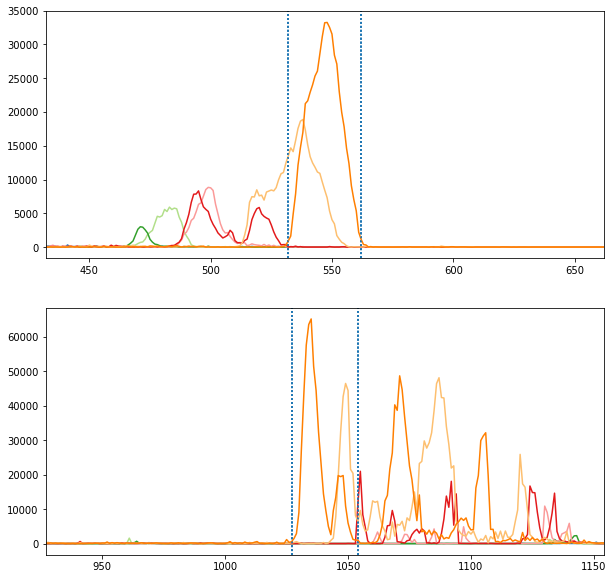

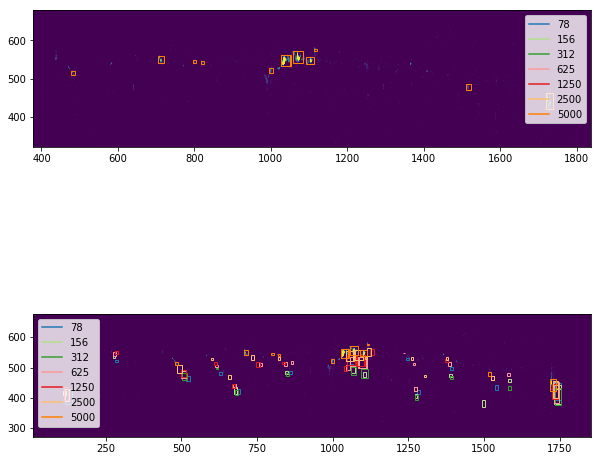

In [128]:
cond = heavy_peaks.M1_area>500#1000
cond &= heavy_peaks.M2_area>500#1000

# peaks = heavy_peaks[cond].sort_values(by='peak_area', ascending=False)
# peak = peaks.iloc[10]

conds = {'M1_area':1000, 'M2_area':1000, 'M1_cosine':0.9, 'M2_cosine':0.9}

pepseq = 'AAAS[+80]VTPPGSLELLQPGFSK[+8]'#'IQAAAST[+80]PTNATAASDANTGDR[+10]'
z = 2

tdf = find_peaks(heavy_peaks, pepseq, z, concentration=5000)
peaks = tdf[cond].sort_values(by='peak_area', ascending=False)
peak = peaks.iloc[0]
plot_mobilograms_by_peak(uimf_files, xic_by_mzbin_objs, colors, target_list_file, heavy_peaks, peak, ppm=20, conds=conds)

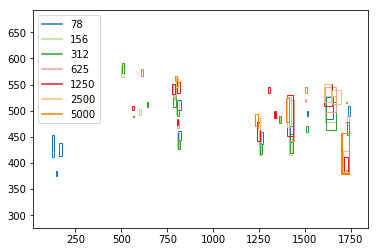

####################################################################################################
M1_area                         338871
M1_cosine                     0.995774
M2_area                          64815
M2_cosine                     0.993179
frame                             1411
frame_end                         1433
frame_start                       1402
peak_area                      1511030
scan                               495
scan_end                           531
scan_start                         451
pepseq           AIGNNSATS[+80]PR[+10]
mono_mass                      1177.52
iso_mass                       1177.52
iso                                  0
z                                    1
concentration                     1250
Name: 38170, dtype: object
('0.347577', '0.0549547', '1.0')
('0.347577', '0.0549547', '1.0') , #mzbins: 9879
('0.347577', '0.0549547', '1.0')
('0.347577', '0.0549547', '1.0') , #mzbins: 9879
('0.347577', '0.0549547', '1.0')
('0.347577',

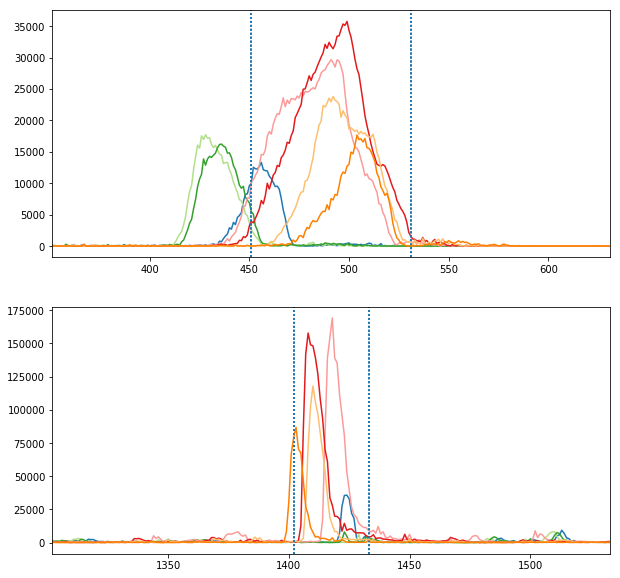

In [78]:
peak = peaks.iloc[800]
plot_peak_regions(heavy_peaks, peak['pepseq'], peak['z'], conds)
plot_mobilograms_by_peak(uimf_files, xic_by_mzbin_objs, colors, target_list_file, peak, ppm=20)

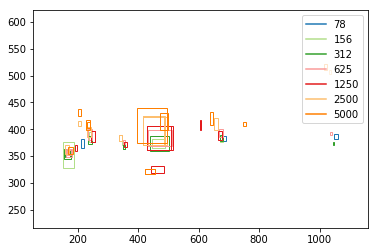

####################################################################################################
M1_area                        3446641
M1_cosine                     0.996809
M2_area                         776092
M2_cosine                     0.979431
frame                              446
frame_end                          495
frame_start                        396
peak_area                      2216320
scan                               411
scan_end                           439
scan_start                         375
pepseq           HLDS[+80]PPAIPPR[+10]
mono_mass                      645.318
iso_mass                       645.318
iso                                  0
z                                    2
concentration                     5000
Name: 59149, dtype: object
('0.347577', '0.0549547', '1.0')
('0.347577', '0.0549547', '1.0') , #mzbins: 9879
('0.347577', '0.0549547', '1.0')
('0.347577', '0.0549547', '1.0') , #mzbins: 9879
('0.347577', '0.0549547', '1.0')
('0.347577',

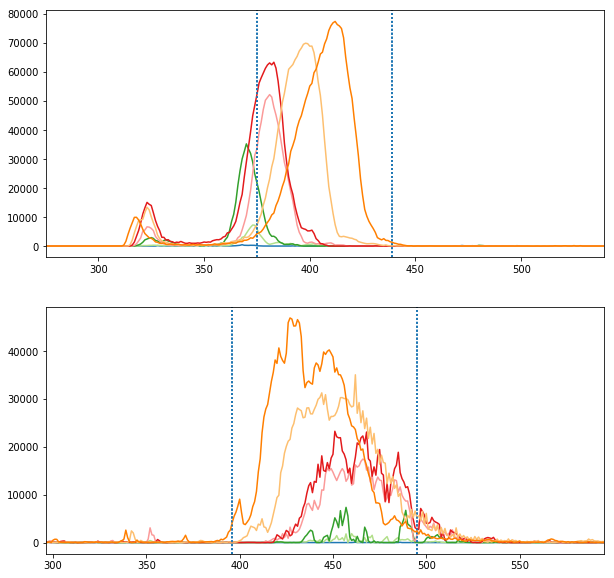

In [79]:
peak = peaks.iloc[430]
plot_peak_regions(heavy_peaks, peak['pepseq'], peak['z'], conds)
plot_mobilograms_by_peak(uimf_files, xic_by_mzbin_objs, colors, target_list_file, peak, ppm=20)